# Capstone Project - The Battle of the Neighborhoods (Week 2)
## Predicting hubs of student population in London for targeted marketing

### Introduction: Business Problem 

London is a huge city covering a whopping area of 607 sq. miles and the purpose of this analysis is to break it down into chunks and identify those neighborhoods where the concentration of students is expected to be high. These neighborhoods, and the accompanying student population, will then be broken down into further clusters for more effective target marketing.

We will start off by installing and importing the libraries and packages that we will need for this project. 

In [85]:
#!pip install pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

#!pip install beautifulsoup4
from bs4 import BeautifulSoup

#!pip install geopy
from geopy.geocoders import Nominatim

#!pip install requests
import requests

#!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

#!pip install scikit-learn
from sklearn.cluster import KMeans

#!pip install folium
import folium 

#!pip install OSGridConverter
from OSGridConverter import grid2latlong
import math
import json
from pandas.io.json import json_normalize

### Data Acquisition and Preprocessing

For the purpose of this analysis, data regarding the neighborhoods and educational institutes of London was required. Data regarding neighborhoods was required so that the city might be broken down into neighborhoods and the target neighborhoods could be identified. Data regarding the location of educational institutes such as colleges and universities was imperative because the target audience i.e. students would most probably be found near or at these locations.

Data for neighborhoods was acquired from Wikipedia and the data for educational institutes was obtained using Foursquare location data. The table obtained from Wikipedia was scrapped using Beautiful Soup.

In [86]:
london_source = "https://en.wikipedia.org/wiki/List_of_areas_of_London"

In [87]:
data  = requests.get(london_source).text
#creating a beautiful soup object
soup = BeautifulSoup(data,"html.parser")
tables = soup.find_all('table')
print('Total number of tables scraped: {}'.format(len(tables)))

Total number of tables scraped: 5


We will now obtain the target table from all the scrapped tables by using unique content. I used one of the OS Grid references for this purpose since these references were only present in the aimed table. 

In [88]:
for index,table in enumerate(tables):
    if ("TQ465785" in str(table)):
        table_index = index
print('The index of the table containing area data is {}'.format(table_index))

The index of the table containing area data is 1


We will now scrape this data and assign it to a dataframe. The data set consists of the following columns:
* Location (Neighborhood)
* Borough
* Post Town
* Post Code District
* Dial Code
* OS Grid reference

In [89]:
table_data=pd.DataFrame(columns=["London Neighborhood", "London borough", "Post town", "Postcode", "Dial code", "OS grid ref"])

In [90]:
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        location = col[0].text
        borough = col[1].text
        post_town = col[2].text
        pc = col[3].text
        dial_code = col[4].text
        os_grid = col[5].text
        table_data = table_data.append({"London Neighborhood":location, "London borough":borough, "Post town":post_town, "Postcode":pc, "Dial code":dial_code, "OS grid ref":os_grid}, ignore_index=True)

print('Sample of data scraped from web source')
print('Number of neighborhoods identified: {}'.format(len(table_data)))
table_data.head()

Sample of data scraped from web source
Number of neighborhoods identified: 531


,London Neighborhood,London borough,Post town,Postcode,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785\n
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805\n
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645\n
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665\n
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728\n


In the sample above, it can be seen that the data requires some cleaning up. This will be our next step.

In [7]:
table_data["London borough"]=table_data["London borough"].str.replace(r"\[.*\]","")
table_data["OS grid ref"] = table_data["OS grid ref"].replace(r'\n',' ', regex=True)
print('Sample of cleaned up data')
table_data.head()

Sample of cleaned up data


<ipython-input-7-270ab68f9208>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  table_data["London borough"]=table_data["London borough"].str.replace(r"\[.*\]","")


,London Neighborhood,London borough,Post town,Postcode,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Now that the data is cleaned up, our next step will be to obtain the location coordinates of the neighborhoods. 

The OS Grid reference was used for this purpose. Some OS Grid references were found missing and were manually fed in the data set. The OSGridConverter package was used to convert these references to location coordinates.

In [8]:
table_data.loc[53,'OS grid ref']='TQ478742'
table_data.loc[232,'OS grid ref']='TQ4453061645'

We will now define a function which we can call to convert the OS Grid references to location coordinates. 

In [9]:
def get_coordinates(OS_Grid_ref):
    OS_Grid_ref=str(OS_Grid_ref)
    l=grid2latlong(OS_Grid_ref)
    lat=l.latitude
    long=l.longitude
    return pd.Series([lat,long])

We will now call this function for all the neighborhoods we have scrapped from our data source.

In [10]:
coordinates = pd.DataFrame(table_data.apply(lambda x: get_coordinates(x["OS grid ref"]),axis=1))
coordinates.rename(columns ={0:'Latitude',1:'Longitude'},inplace = True)
print('Sample of location coordinates')
coordinates.head()

Sample of location coordinates


,Latitude,Longitude
0,51.486484,0.109318
1,51.510591,-0.264585
2,51.362934,-0.025780
3,51.381625,-0.068126
4,51.434929,0.125663


We will now add these coordinates to our original table. Since, information regarding 'Dial Code' and 'Post Town' was not relevant for this project, these columns were dropped. We will also drop the 'OS grid reference' column since it's no longer required. 

In [11]:
table_data['Latitude']=coordinates['Latitude']
table_data['Longitude']=coordinates['Longitude']
table_data=table_data.drop(['Post town','Dial code','OS grid ref'], axis=1)
print('Sample of final neighberhood data')
table_data.head()

Sample of final neighberhood data


,London Neighborhood,London borough,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.486484,0.109318
1,Acton,"Ealing, Hammersmith and Fulham","W3, W4",51.510591,-0.264585
2,Addington,Croydon,CR0,51.362934,-0.025780
3,Addiscombe,Croydon,CR0,51.381625,-0.068126
4,Albany Park,Bexley,"DA5, DA14",51.434929,0.125663


The information regarding neighborhoods and location coordinates will now be fed into the Foursquare API along with a ‘search’ query for educational institutes to identify possible student hubs in the neighborhoods. 

Foursquare credentials are defined in the hidden cell bellow.

In [19]:
#Foursquare credentials are hidden
VERSION='20180605'

Our next step will be to define a search query for the Foursquare API. I tried several queries and got the most relevant results with the query 'college university'.The search results for each neighborhood were limited to 20 to avoid overlap between neighborhoods and the radius was kept at 1000m. 

In [20]:
QUERY='college university'
radius=1000
limit=20

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
#function for extracting nearby venues
def getNearbyVenues(names, lat, lng,radius,limit):
        url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION,
            QUERY,
            radius,
            limit)
        results = requests.get(url2).json()
        venues = results['response']['venues']
        dataframe = pd.json_normalize(venues)
        
        if len(dataframe.columns) == 0:
            return None
        
        else:
            filtered_columns = ['name', 'categories','location.distance','location.address','location.lat','location.lng','location.postalCode']
            temp_df = dataframe.reindex(columns = filtered_columns)
            #filter the category for each row
            temp_df['categories'] = temp_df.apply(get_category_type, axis=1)
            temp_df.insert(0, 'LondonNeighborhood', names)
            temp_df.insert(1,'NeighborhoodLatitude',lat)
            temp_df.insert(2,'NeighborhoodLongitude',lng)
            temp_df.columns = ['LondonNeighborhood', 
                             'NeighborhoodLatitude', 
                             'NeighborhoodLongitude', 
                             'VenueName',
                             'VenueCategory',
                             'VenueDistance',
                             'VenueAddress',
                             'VenueLat',
                             'VenueLng',
                             'VenuePostalCode'
                             ]
            return temp_df

We will use the search query and the functions defined above to extract the required data regarding educational institutes. Apart from the venue name and category, relevant location data was kept on record for further analysis and for possible use by companies and institutes targeting students. This includes:
* Distance of venue from neighborhood coordinates
* Venue Address
* Venue coordinates
* Venue postal code

Information returned by Foursquare deemed irrelevant was dropped.

In [50]:
london_venues=pd.DataFrame(columns=['LondonNeighborhood', 
                             'NeighborhoodLatitude', 
                             'NeighborhoodLongitude', 
                             'VenueName',
                             'VenueCategory',
                             'VenueDistance',
                             'VenueAddress',
                             'VenueLat',
                             'VenueLng',
                             'VenuePostalCode'
                             ])

for i in range(len(table_data)):
    print(table_data.loc[i,'London Neighborhood'])
    temp=getNearbyVenues(table_data.loc[i,'London Neighborhood'], table_data.loc[i,'Latitude'], table_data.loc[i,'Longitude'],radius,limit)
    london_venues=london_venues.append(temp)
    
london_venues.reset_index(inplace=True)
london_venues.drop('index',axis=1,inplace=True)
print('Sample of data regarding neighborhoods and nearby education institutes')
london_venues.head()

Abbey Wood
Acton
Addington
Addiscombe
Albany Park
Aldborough Hatch
Aldgate
Aldwych
Alperton
Anerley
Angel
Aperfield
Archway
Ardleigh Green
Arkley
Arnos Grove
Balham
Bankside
Barbican
Barking
Barkingside
Barnehurst
Barnes
Barnes Cray
Barnet Gate
Barnet (also Chipping Barnet, High Barnet)
Barnsbury
Battersea
Bayswater
Beckenham
Beckton
Becontree
Becontree Heath
Beddington
Bedford Park
Belgravia
Bellingham
Belmont
Belmont
Belsize Park
Belvedere
Bermondsey
Berrylands
Bethnal Green
Bexley (also Old Bexley, Bexley Village)
Bexleyheath (also Bexley New Town)
Bickley
Biggin Hill
Blackfen
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Blendon
Bloomsbury
Botany Bay
Bounds Green
Bow
Bowes Park
Brentford
Brent Cross
Brent Park
Brimsdown
Brixton
Brockley
Bromley
Bromley (also Bromley-by-Bow)
Bromley Common
Brompton
Brondesbury
Brunswick Park
Bulls Cross
Burnt Oak
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Carshalton
Castelnau
Cast

,LondonNeighborhood,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueCategory,VenueDistance,VenueAddress,VenueLat,VenueLng,VenuePostalCode
0,Acton,51.510591,-0.264585,ABI COLLEGE,University,673,"3 The Mount, Acton, London, W3 9NW",51.508142,-0.273478,W3 9NW
1,Acton,51.510591,-0.264585,Queensland College London,College & University,617,3 The Mount,51.507554,-0.272040,W3 9NW
2,Acton,51.510591,-0.264585,sofa college london,College Academic Building,853,NaN,51.505015,-0.256132,NaN
3,Acton,51.510591,-0.264585,Brookwood College,Private School,870,296 High St,51.508484,-0.276686,W3 9BJ
4,Acton,51.510591,-0.264585,"Ealing, Hammersmith & West London College",College Classroom,879,Gunnersbury Ln.,51.507594,-0.276329,W3 8UX


### Methodology and Data Analysis

The first part of our analysis will be to study the venue categories and shortlist/modify them to obtain relevant data. 

In [51]:
venue_cat=london_venues['VenueCategory'].unique()
venue_cat_df=pd.DataFrame(venue_cat, columns=['Categories'])
print('A total of {} categories were extracted'.format(len(venue_cat_df)))
venue_cat_df

A total of 127 categories were extracted


,Categories
0,University
1,College & University
2,College Academic Building
3,Private School
4,College Classroom
5,General College & University
6,None
7,Bus Stop
8,College Library
9,College Arts Building


In the data above, it may be seen that some of the categories such as Bus Stop and Church are irrelevant. Also, some of the categories are overlapping; for instance, categories such as College Arts Building, College Administrative Building are superfluous since they are parts of venues that are already covered in other categories. Further inspection of the data revealed that the category 'College Academic Building' included colleges and universities. This category along with other categories containing colleges and universities were grouped under one umbrella category called 'General College & University' to make further analysis more meaningful since they all contained similar venues. 

In [52]:
backup=london_venues
london_venues['VenueCategory'] = london_venues['VenueCategory'].replace(['College Academic Building','College & University','University'],'General College & University')

Once the categories were shortlisted, they were used to further narrow down our neighborhoods of interest. The final list of neighborhoods obtained after this step will serve as our target neighborhoods containing student hubs. 

In [53]:
look_for=  ['Adult Education Center',
            'College Residence Hall',
            'Community College',
            'Coworking Space',
            'General College & University',
            'Government Building',
            'High School',
            'Language School',
            'Law School',
            'Medical School',
            'Music School',
            'Private School',
            'Residential Building (Apartment / Condo)',
            'School',
            'Trade School']
shortlist= london_venues[pd.DataFrame(london_venues['VenueCategory'].tolist()).isin(look_for).any(1).values]

print(shortlist.shape)
shortlist.head(3)

(1297, 10)


,LondonNeighborhood,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueCategory,VenueDistance,VenueAddress,VenueLat,VenueLng,VenuePostalCode
0,Acton,51.510591,-0.264585,ABI COLLEGE,General College & University,673,"3 The Mount, Acton, London, W3 9NW",51.508142,-0.273478,W3 9NW
1,Acton,51.510591,-0.264585,Queensland College London,General College & University,617,3 The Mount,51.507554,-0.272040,W3 9NW
2,Acton,51.510591,-0.264585,sofa college london,General College & University,853,NaN,51.505015,-0.256132,NaN


In [54]:
Neighborhood_target=shortlist.groupby('LondonNeighborhood').mean()
Neighborhood_target=Neighborhood_target.drop(['VenueLat','VenueLng'],axis=1).reset_index()

In [55]:
Neighborhood_target.head()

,LondonNeighborhood,NeighborhoodLatitude,NeighborhoodLongitude
0,Acton,51.510591,-0.264585
1,Aldgate,51.514885,-0.078356
2,Aldwych,51.512819,-0.117388
3,Alperton,51.537976,-0.292401
4,Anerley,51.408585,-0.066989


We will now plot these neighborhoods on a map to study their distribution.

In [56]:
address = 'London, UK'

geolocator = Nominatim(user_agent="on_search")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [57]:
# create map of UK using latitude and longitude values

map_UK = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(Neighborhood_target['NeighborhoodLatitude'], Neighborhood_target['NeighborhoodLongitude'], Neighborhood_target['LondonNeighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_UK)  
    
map_UK

In the map above, it maybe seen that most of our neighborhoods of interest are located towards the center of London. The density of student hubs is diminishing the further we move away from the center. Hence, a broad suggestion for our stake holders would be to concentrate their marketing efforts towards the center of the city. 

The next part of our analysis will be to further breakdown these neighborhoods into clusters depending upon the extracted information. 

We will use encoding to quantify which categories are present in our shortlisted neighborhoods. 

In [58]:
# one hot encoding
london_onehot = pd.get_dummies(shortlist[['VenueCategory']], prefix="", prefix_sep="")
london_onehot

london_onehot.insert(0, "LondonNeighborhood", shortlist["LondonNeighborhood"], True)
london_onehot.insert(1, "NeighborhoodLatitude", shortlist["NeighborhoodLatitude"], True)
london_onehot.insert(2, "NeighborhoodLongitude", shortlist["NeighborhoodLongitude"], True)

london_onehot.head()

,LondonNeighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Adult Education Center,Building,College Residence Hall,Community College,Coworking Space,General College & University,Government Building,High School,Language School,Law School,Medical School,Music School,Private School,Residential Building (Apartment / Condo),School,Trade School
0,Acton,51.510591,-0.264585,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Acton,51.510591,-0.264585,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Acton,51.510591,-0.264585,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Acton,51.510591,-0.264585,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,Aldgate,51.514885,-0.078356,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by take the mean of the frequency of occurrence of each category. This dataset will be used for forming clusters which will be our next step. 

In [76]:
london_grouped = london_onehot.groupby('LondonNeighborhood').mean().reset_index()
london_grouped.head()

,LondonNeighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Adult Education Center,Building,College Residence Hall,Community College,Coworking Space,General College & University,Government Building,High School,Language School,Law School,Medical School,Music School,Private School,Residential Building (Apartment / Condo),School,Trade School
0,Acton,51.510591,-0.264585,0.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0
1,Aldgate,51.514885,-0.078356,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.2,0.000000,0.0,0.00,0.0,0.0,0.0
2,Aldwych,51.512819,-0.117388,0.0,0.0,0.0,0.0,0.0,0.777778,0.0,0.0,0.0,0.0,0.222222,0.0,0.00,0.0,0.0,0.0
3,Alperton,51.537976,-0.292401,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.000000,0.0,0.50,0.0,0.0,0.0
4,Anerley,51.408585,-0.066989,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0


We will now run k-means to cluster the neighborhood into 4 clusters. I tried different values and the most relevant and insightful clusters were obtained with a value of 4.

In [77]:
# set number of clusters
kclusters = 4

london_grouped_clustering = london_grouped.drop('LondonNeighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the venue categories for each neighborhood

In [78]:
london_grouped.insert(0, 'ClusterLabels', kmeans.labels_)
london_grouped.head()

,ClusterLabels,LondonNeighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Adult Education Center,Building,College Residence Hall,Community College,Coworking Space,General College & University,Government Building,High School,Language School,Law School,Medical School,Music School,Private School,Residential Building (Apartment / Condo),School,Trade School
0,0,Acton,51.510591,-0.264585,0.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0
1,0,Aldgate,51.514885,-0.078356,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.2,0.000000,0.0,0.00,0.0,0.0,0.0
2,0,Aldwych,51.512819,-0.117388,0.0,0.0,0.0,0.0,0.0,0.777778,0.0,0.0,0.0,0.0,0.222222,0.0,0.00,0.0,0.0,0.0
3,0,Alperton,51.537976,-0.292401,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.000000,0.0,0.50,0.0,0.0,0.0
4,0,Anerley,51.408585,-0.066989,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0


We will now visualize these clusters by plotting them on London's map similar to the map of neighborhoods above 

In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
rainbow=['firebrick','mediumblue','limegreen','yellow','orange','purple']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_grouped['NeighborhoodLatitude'], london_grouped['NeighborhoodLongitude'], london_grouped['LondonNeighborhood'], london_grouped['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's check how many neighborhoods each cluster has.

In [80]:
cluster_count=london_grouped.groupby('ClusterLabels').count()
cluster_count

,LondonNeighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Adult Education Center,Building,College Residence Hall,Community College,Coworking Space,General College & University,Government Building,High School,Language School,Law School,Medical School,Music School,Private School,Residential Building (Apartment / Condo),School,Trade School
ClusterLabels,,,,,,,,,,,,,,,,,,,
0,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248
1,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
2,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
3,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22


Based on the table above, it maybe seen that Cluster 0 contains the maximum number of neighborhoods and Cluster 2 and 3 have the minimum number. We will now further explore these clusters by plotting barcharts for each cluster. 

We will group the data by clusters and obtain the mean of the frequency of each venue. Further we will drop the columns containing location coordinates since they are not relevant for further analysis. 

In [81]:
cluster_data=london_grouped.groupby('ClusterLabels').mean()
cluster_data=cluster_data.drop(['NeighborhoodLatitude','NeighborhoodLongitude'],axis=1)
cluster_data.head()

,Adult Education Center,Building,College Residence Hall,Community College,Coworking Space,General College & University,Government Building,High School,Language School,Law School,Medical School,Music School,Private School,Residential Building (Apartment / Condo),School,Trade School
ClusterLabels,,,,,,,,,,,,,,,,
0,0.001136,0.019966,0.025023,0.056624,0.001703,0.802183,0.00176,0.009852,0.002352,0.012401,0.018391,0.000403,0.004032,0.016085,0.014568,0.013523
1,0.022222,0.008889,0.127513,0.034444,0.000000,0.162063,0.00000,0.025397,0.000000,0.044444,0.004444,0.044444,0.034074,0.000000,0.457989,0.034074
2,0.000000,0.000000,0.000000,0.969697,0.000000,0.015152,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000
3,0.000000,0.000000,0.000000,0.022727,0.000000,0.189394,0.00000,0.772727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000


We will now transpose the data for plotting the barcharts. 

In [82]:
cluster_t=cluster_data.transpose()
cluster_t.columns.name = None
cluster_t.head()

,0,1,2,3
Adult Education Center,0.001136,0.022222,0.000000,0.000000
Building,0.019966,0.008889,0.000000,0.000000
College Residence Hall,0.025023,0.127513,0.000000,0.000000
Community College,0.056624,0.034444,0.969697,0.022727
Coworking Space,0.001703,0.000000,0.000000,0.000000


Plotting the barcharts...

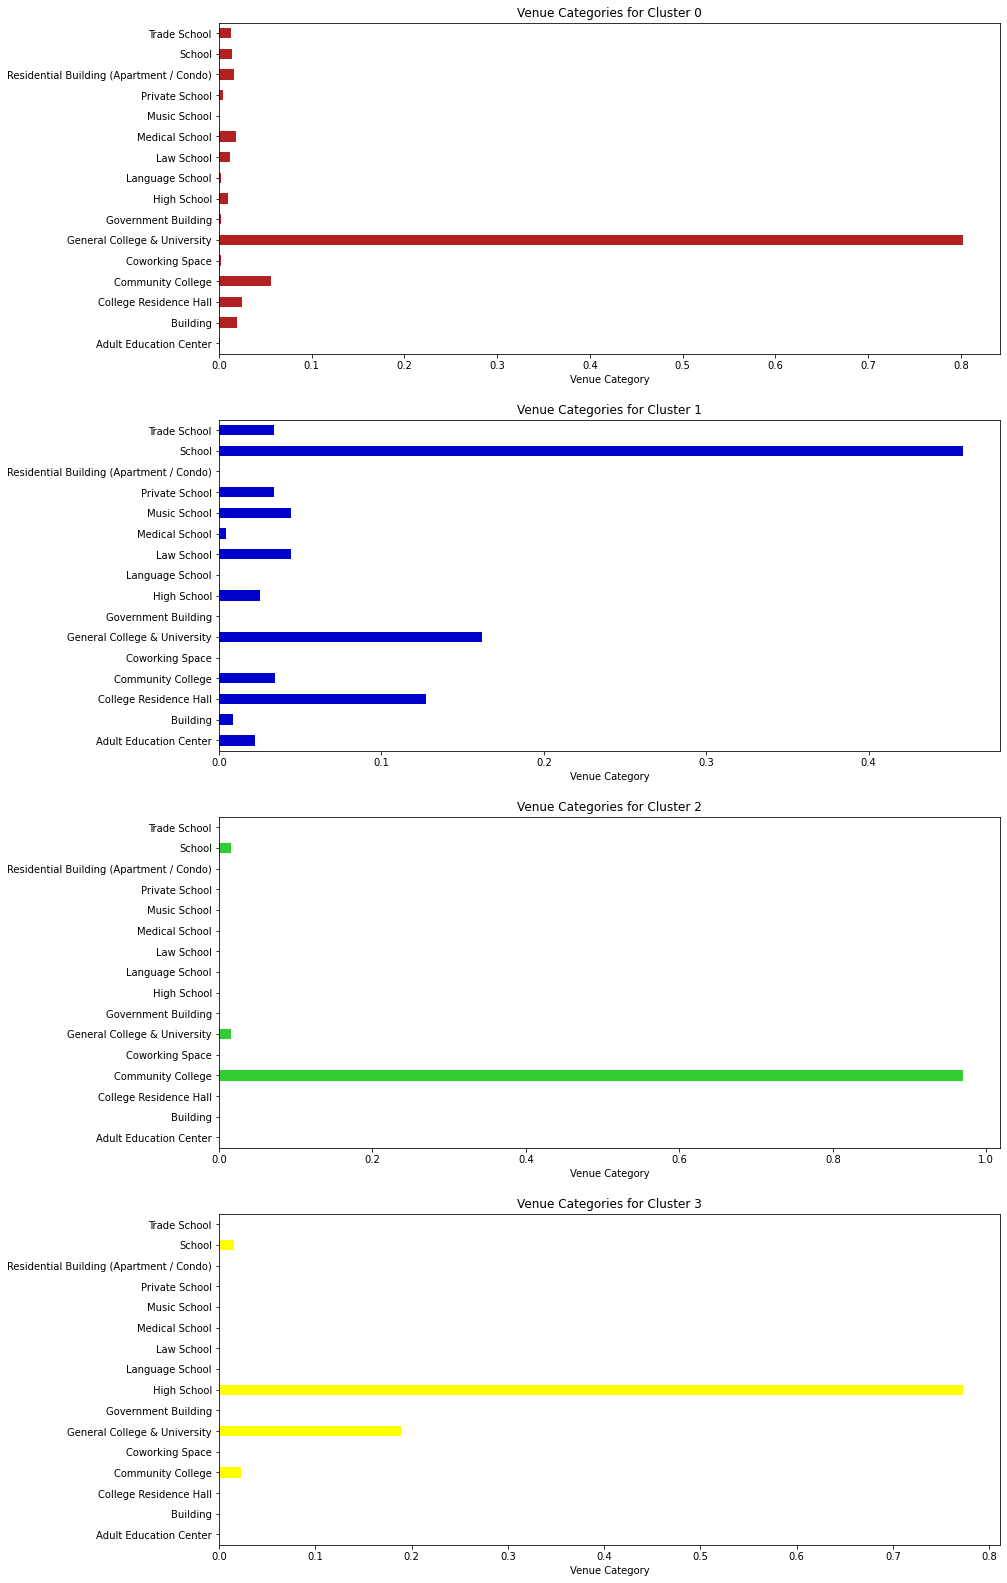

In [83]:

row=math.ceil(kclusters/2)
fig=plt.figure(figsize=(14,7*kclusters))

for i in range(kclusters):
    plt.subplot(kclusters,1, i+1)
    cluster_t[i].plot(kind='barh',color=rainbow[i])
    plt.xlabel('Venue Category') # add to x-label to the plot
    plt.title('Venue Categories for Cluster {}'.format(i)) # add title to the plot
    
plt.show()

In the figures above, it may be seen that:
•	Cluster 0 mostly consists of universities and colleges and is the largest cluster. 
•	Cluster 2 mostly almost purely consists of community colleges.
•	Cluster 3 mostly consists of high schools.
•	Cluster 1 is an amalgam of categories which are smaller in number than the categories already discussed but relevant, nevertheless. This includes student residential buildings, private schools, adult education centers, etc.  Schools have the highest frequency of venue category in this cluster. 


### Findings:

* Most of our neighborhoods of interest are concentrated towards the center of London. The density of student hubs is diminishing the further we move away from the center. Hence, a broad suggestion for our stake holders would be to concentrate their marketing efforts towards the center of the city for targeting students. 

* If the stakeholders want to target college and university students, then they should focus on the neighborhoods contained in Cluster 0. These neighborhoods are mostly concentrated towards the center of the city.

* If the stakeholders want to target community colleges, then their areas of interest fall in Cluster 2. These areas cane be mostly seen scattered at the peripherals of the city. 

* Stakeholders, such as universities targeting future students, can target areas in Cluster 3 and some parts of Cluster 1 to reach their intended audience. These areas are smaller in number but are spread throughout the city. This noted smaller number of schools could be because of the search query used which does not include the word ‘school’. However, it was observed that including the word school in the search query was deviating the focus of the search away from our intended age group which is why it was dropped. 

* Stakeholders interested in reaching and engaging a mixed audience instead of concentrating on specific vendor categories can focus on Cluster 1 for targeted marketing. 


### Conclusion

In this analysis, hubs of student population in London were defined for targeted marketing and. Based on the assumption that the presence of educational institutes is indicative of the presence of students, it was found out that most of our areas of interest in this regard are concentrated towards central London. This student population was then further broken down into clusters so that companies and educational institutes can target specific student populations. Three distinctive categories of students were obtained in this regard:
*	Students belonging to colleges and universities who make up the largest number of the student population and are mostly concentrated towards the center of the city.
*	Community colleges which are mostly located towards the peripherals of the city.
*	School students who are spread throughout the city. 
These findings effectively address the problem of locating student hubs in the city of London for effective target marketing, which was the intended purpose of this analysis  
